# Semi-Synthetic FICO Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import causalml as cml

## Data Preprocessing

In [2]:
HelocData = pd.read_csv('Heloc/heloc_dataset_v1.csv')

In [3]:
from scipy.special import expit
from sklearn.ensemble import HistGradientBoostingClassifier

def generate_data(heloc_data, num_iv_levels, confounding_type='nucem', confounding_strength=0.5, random_seed=666):

    # Step 1: Factorize the binary-valued label and standardization
    data = heloc_data.copy()
    def standardization(df):
        return ( df - df.mean(axis=0) ) / df.std(axis=0)
        
    features = data.columns[1:].to_list()
    data[features] = standardization(data[features])
    data['RiskPerformance'] = pd.factorize(data['RiskPerformance'])[0]

    # Step 2: Specify the observed and unobserved features
    X = data[features]
    y = data['RiskPerformance']

    reg = HistGradientBoostingClassifier(max_iter=200)
    reg.fit(X, y)
    # print('Classification error: ', reg.score(X, y))

    U = y - pd.DataFrame(reg.predict_proba(X))[1]

    # Step 3: Generate instrumental variable Z
    Z = np.random.choice(range(1, num_iv_levels + 1), size=data.shape[0])

    # Step 4: Generate missing decision
    np.random.seed(random_seed)
    X1 = data['ExternalRiskEstimate']

    if confounding_type == 'nucem':
        D_prob = confounding_strength * expit(5 * U) + (1 - confounding_strength) * expit((1 + Z) * X1)
    elif confounding_type == 'uc':
        D_prob = expit(confounding_strength * (5 * U) + (1 - confounding_strength) * (1 + Z) * X1)
    else:
        raise ValueError("Invalid ztype. Must be 'nucem' or 'uc'.")
    D = np.random.binomial(1, D_prob)

    # Step 5: Return the aggregate data and parameters
    data = data.assign(U=U, Z=Z, D=D)
    params = {
        'observables': features,
        'instrument': 'Z',
        'decision': 'D',
        'outcome': 'RiskPerformance'
    }

    return data, params

In [4]:
data, params = generate_data(HelocData, num_iv_levels=6, confounding_type='uc', confounding_strength=0.5)

In [5]:
data

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,U,Z,D
0,0,-0.588296,-0.366557,-0.341568,0.261887,0.043981,1.176359,0.060338,-0.140831,-0.232298,...,-0.258486,0.045579,-1.120121,1.091050,0.005886,0.292403,0.249745,-0.237467,5,0
1,0,-0.304227,-1.150629,0.485391,-0.846852,-1.340173,1.574146,1.749957,0.513026,-0.671296,...,-0.258486,-1.052220,-1.120121,-0.721705,-2.210319,-2.387656,-2.240190,-0.182412,3,1
2,0,-0.020157,-1.077692,-0.266390,-1.285191,-0.801891,-0.017001,0.060338,0.513026,-0.671296,...,1.013901,0.710912,0.637531,0.184673,0.252131,0.292403,0.863208,-0.198284,6,1
3,0,-0.067502,-0.138629,-0.567103,-0.021744,0.659161,0.380786,0.482743,0.243791,3.377238,...,1.013901,1.342978,1.041317,0.637861,0.744621,0.887972,1.043638,-0.238699,1,1
4,0,0.642670,1.356578,1.387528,1.499549,-0.571199,-0.017001,0.060338,0.513026,-0.671296,...,0.059611,0.644379,1.183829,-0.041922,0.005886,-0.005381,0.646692,-0.585236,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,1,0.263912,-0.485080,-0.266390,-0.434298,0.120879,-0.017001,0.060338,0.320715,3.572348,...,-0.258486,-0.187287,-1.120121,0.411267,0.252131,-0.005381,1.368412,0.380105,2,1
10455,0,-0.114847,-0.339206,2.289665,-0.150667,-0.648096,-0.017001,0.060338,0.205329,1.035917,...,0.059611,1.808711,0.328755,-0.268516,0.252131,0.292403,0.646692,-0.216110,5,0
10456,0,0.311257,-0.503314,-0.191212,-0.253806,-0.109814,0.380786,0.482743,0.513026,-0.671296,...,1.013901,-0.852620,-1.120121,0.411267,-2.210319,-0.005381,-0.219373,-0.653452,5,1
10457,0,0.216567,0.453983,0.259856,1.009641,1.735726,0.778573,0.905147,0.359177,1.377360,...,-0.258486,-0.420154,-1.120121,0.184673,0.005886,-0.005381,-0.868921,-0.775284,1,0


In [6]:
data.corr()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,U,Z,D
RiskPerformance,1.000000,0.216770,0.185155,0.046937,0.209168,0.123080,-0.067211,-0.043402,0.122010,-0.057067,...,-0.076660,-0.298174,-0.083645,-0.050099,-0.034337,-0.029091,-0.198554,0.856452,0.007746,0.487090
ExternalRiskEstimate,0.216770,1.000000,0.477272,0.326204,0.584799,0.473782,0.684661,0.741375,0.895690,0.091850,...,0.611987,0.040390,0.159683,0.508414,0.462768,0.514849,0.402654,0.001996,0.006115,0.400842
MSinceOldestTradeOpen,0.185155,0.477272,1.000000,0.219878,0.725988,0.414862,0.370034,0.380408,0.400114,0.109667,...,0.271127,0.026828,0.032821,0.389226,0.206814,0.345081,0.127794,0.003070,0.015147,0.213404
MSinceMostRecentTradeOpen,0.046937,0.326204,0.219878,1.000000,0.493960,-0.028660,0.294822,0.304760,0.240334,0.019798,...,0.142192,0.028897,-0.156797,0.064387,-0.020523,0.087324,0.178142,-0.002686,-0.007985,0.129804
AverageMInFile,0.209168,0.584799,0.725988,0.493960,1.000000,0.359832,0.473571,0.480983,0.451750,0.126157,...,0.299182,0.028779,-0.047407,0.375460,0.163037,0.354238,0.188197,0.007530,-0.001540,0.255261
NumSatisfactoryTrades,0.123080,0.473782,0.414862,-0.028660,0.359832,1.000000,0.420207,0.447632,0.577202,0.123848,...,0.460724,0.149447,0.297483,0.674215,0.542805,0.564977,0.191318,0.009030,-0.002276,0.171650
NumTrades60Ever2DerogPubRec,-0.067211,0.684661,0.370034,0.294822,0.473571,0.420207,1.000000,0.975480,0.675845,0.273697,...,0.681080,0.326146,0.252372,0.570133,0.533840,0.545074,0.589809,-0.006223,0.000837,0.164313
NumTrades90Ever2DerogPubRec,-0.043402,0.741375,0.380408,0.304760,0.480983,0.447632,0.975480,1.000000,0.751725,0.247193,...,0.706904,0.320792,0.258830,0.591946,0.547489,0.567947,0.600332,-0.005369,0.003049,0.191331
PercentTradesNeverDelq,0.122010,0.895690,0.400114,0.240334,0.451750,0.577202,0.675845,0.751725,1.000000,0.046771,...,0.686419,0.237838,0.264564,0.642399,0.549565,0.631757,0.502780,0.003451,0.004603,0.314480
MSinceMostRecentDelq,-0.057067,0.091850,0.109667,0.019798,0.126157,0.123848,0.273697,0.247193,0.046771,1.000000,...,0.152159,0.126058,0.087071,0.142735,0.142514,0.117593,0.156383,0.005028,0.016188,-0.000286


In [7]:
from sklearn.ensemble import HistGradientBoostingClassifier

def unmeasured_confounding(dataset, features, decision, outcome):
    X = dataset[features]
    D = dataset[decision]
    Y = dataset[outcome]
    
    modelD = HistGradientBoostingClassifier(max_iter=200)
    modelY = HistGradientBoostingClassifier(max_iter=200)
    
    modelD.fit(X, D)
    modelY.fit(X, Y)
    
    resD = D - pd.DataFrame(modelD.predict_proba(X) )[1].values
    resY = Y - pd.DataFrame(modelY.predict_proba(X) )[1].values
    
    corr = np.corrcoef(resD, resY)[0, 1]
    
    return corr

## evaluate the strength of unmeasured confounding
unmeasured_confounding(dataset=data, features=params['observables'], decision=params['decision'], outcome=params['outcome'] )

np.float64(0.39906226397750183)

## Classification with Selective Labels

In [8]:
acc_selected = cml.Classification(Sample=data, Params=params, Selective=True, IPW=False, k_folds=5, random_state=300)
acc_selected

{'LogisticRegression': np.float64(0.638),
 'SVM': np.float64(0.61),
 'RandomForest': np.float64(0.643),
 'GradientBoosting': np.float64(0.641),
 'AdaBoost': np.float64(0.655)}

In [9]:
Acc_df = pd.DataFrame(columns=['Selective'], index=acc_selected.keys(), data=acc_selected.values())
Acc_df

,Selective
LogisticRegression,0.638
SVM,0.610
RandomForest,0.643
GradientBoosting,0.641
AdaBoost,0.655


In [10]:
acc_selected_ipw = cml.Classification(Sample=data, Params=params, Selective=True, IPW=True, k_folds=5, random_state=300)

In [11]:
Acc_df['Selective IPW'] = acc_selected_ipw.values()
Acc_df

,Selective,Selective IPW
LogisticRegression,0.638,0.627
SVM,0.610,0.628
RandomForest,0.643,0.628
GradientBoosting,0.641,0.629
AdaBoost,0.655,0.621


## Classification with Full Labels

In [12]:
acc_full = cml.Classification(Sample=data, Params=params, Selective=False, IPW=False, k_folds=5, random_state=300)

In [13]:
Acc_df['Full'] = acc_full.values()
Acc_df

,Selective,Selective IPW,Full
LogisticRegression,0.638,0.627,0.720
SVM,0.610,0.628,0.724
RandomForest,0.643,0.628,0.721
GradientBoosting,0.641,0.629,0.717
AdaBoost,0.655,0.621,0.722


### DR Learner
- Rambachan, Ashesh, Amanda Coston, and Edward Kennedy. "Counterfactual risk assessments under unmeasured confounding." arXiv preprint arXiv:2212.09844 (2022)

- Binary outcome $Y^{\star} = Y(1) \in \{0, 1 \}$ with binary decision $D \in \{0, 1\}$.

- Identify the conditional probability $\mu^{\star}(X) := \mathbb{E}[Y^{\star} \mid X] = \mathbb{P}(Y^{\star} = 1 \mid X)$.

- Define some nuisance functions:
    - $\mu_1(X) := \mathbb{E}[Y \mid D = 1, X] = \mathbb{E}[Y^{\star} \mid D = 1, X] $.
    - $\delta(X) := \mathbb{E}[Y^{\star} \mid D = 0, X] - \mathbb{E}[Y^{\star} \mid D = 1, X]$.
    - $\pi_0(X) := \mathbb{P}(D = 0 \mid X)$ and $\pi_1(X) := \mathbb{P}(D = 1 \mid X)$.

- Obviously, the conditional mean outcome can be identifed as 
    $$ 
    \mu^{\star}(X) = \mu_1(X) + \delta(X) \cdot \pi_0(X).
    $$

- Both $\mu_1(X)$ and $\pi_0(X)$ can be estimated from observed data $(Y_i, D_i, X_i)_{i=1}^{n}$.

- However, the difference $\delta(X)$ can not be identified without unconfoundedness.

- By incorporating the Mean Outcome Sensitivity Model (MOSM), once we derive a bound for $\delta(x)$, that is, $\underline{\delta}(x) \leq \delta(x) \leq \overline{\delta}(x)$, we may derive a partial bound for the conditional mean outcome
$$
    \mu_1(X) + \underline{\delta}(X) \pi_0(X) \leq \mu^{\star}(X) \leq \mu_1(X) + \overline{\delta}(X) \pi_0(X).
$$

- The doubly robust (DR) version of upper bound of $\mu^{\star}(X)$ can be formalized as 
$$
    \overline{\mu}_{\rm DR}(X) = \left(\mu_1(X) + \frac{D (Y - \mu_1(X))}{\pi_1(X)} \right) + \overline{\delta}(X) \pi_0(X).
$$

- We can choose the tight IV bound is $\underline{\delta}_z(x) \leq \delta(x) \pi_0(x) \leq \overline{\delta}_z(x)$ for all $z \in \mathcal{Z}$,
$$
    \overline{\delta}(x) := \min_{z} \overline{\delta}_z(x) = \min_{z} \big\{\pi_0(x, z) + \mathbb{E}[DY \mid X = x, Z = z] - \mu_1(x)\big\}，
$$
where $\pi_0(x, z) = \mathbb{P}(D = 0 \mid X = x, Z = z)$.

- Let $\hat{\overline{\mu}}_{\rm DR}(X)$ be the estimated upper bound of true conditional probability, that is
$$
    \hat{\overline{\mu}}_{\rm DR}(X) = \left(\hat{\mu}_1(X) + \frac{D (Y - \hat{\mu}_1(X)) }{\hat{\pi}_1(X)} \right) + \hat{\overline{\delta}}(X)
$$


In [14]:
acc_dr = cml.DRLearner(Sample=data, Params=params, k_folds=5, random_state=200)

In [15]:
acc_dr

np.float64(0.577)

## Partial Learning with Selective Labels

In [14]:
acc_partial = cml.WeightedClassification(Sample=data, Params=params, WeightFunc=cml.IVPartialWeightBinary, k_folds=5, random_state=200)

In [16]:
Acc_df['Partial ID'] = acc_partial.values()
Acc_df

,Selective,Selective IPW,Full,Partial ID
LogisticRegression,0.638,0.643,0.720,0.704
SVM,0.623,0.636,0.724,0.709
RandomForest,0.642,0.629,0.721,0.714
GradientBoosting,0.642,0.647,0.717,0.715
AdaBoost,0.652,0.641,0.722,0.697


## Point Learning with Selective Labels

In [17]:
acc_point = cml.WeightedClassification(Sample=data, Params=params, WeightFunc=cml.IVPointWeightBinary, k_folds=5, random_state=300)

In [31]:
Acc_df['Point ID'] = acc_point.values()
Acc_df

,Selective,Selective IPW,Full,Partial ID,Point ID
LogisticRegression,0.643,0.639,0.720,0.650,0.668
SVM,0.625,0.633,0.724,0.641,0.639
RandomForest,0.645,0.643,0.723,0.650,0.648
GradientBoosting,0.646,0.649,0.717,0.651,0.619
AdaBoost,0.644,0.650,0.722,0.646,0.630


# The Results of Repeated Experiments

In [2]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## NUCEM model

In [3]:
confounding_strength_values = [0.5, 0.7, 0.9]
ACC_pickles_nucem = dict()

for confounding_strength in confounding_strength_values:
    with open(f'FICO-10-04/FICO-Accuracy-Type-nucem-Strength-{confounding_strength}.pickle', 'rb') as handle:
        ACC_pickles_nucem[confounding_strength] = pickle.load(handle)

In [4]:
ACC_pickles_nucem

{0.5: [                    Selected Sample  Selected Sample (IPW)  Full Sample  \
  LogisticRegression            0.660                  0.663        0.716   
  SVM                           0.661                  0.671        0.720   
  RandomForest                  0.661                  0.677        0.715   
  GradientBoosting              0.673                  0.674        0.723   
  AdaBoost                      0.671                  0.674        0.720   
  
                      Point Learning  Partial Learning  
  LogisticRegression           0.700             0.691  
  SVM                          0.704             0.697  
  RandomForest                 0.710             0.681  
  GradientBoosting             0.685             0.708  
  AdaBoost                     0.707             0.687  ,
                      Selected Sample  Selected Sample (IPW)  Full Sample  \
  LogisticRegression            0.654                  0.656        0.716   
  SVM                           0

In [5]:
# pd.concat(ACC_pickles_nucem[0.5], axis=0).stack()


Text(0.5, 1.08, 'Accuracy Scores (Model NUCEM)')

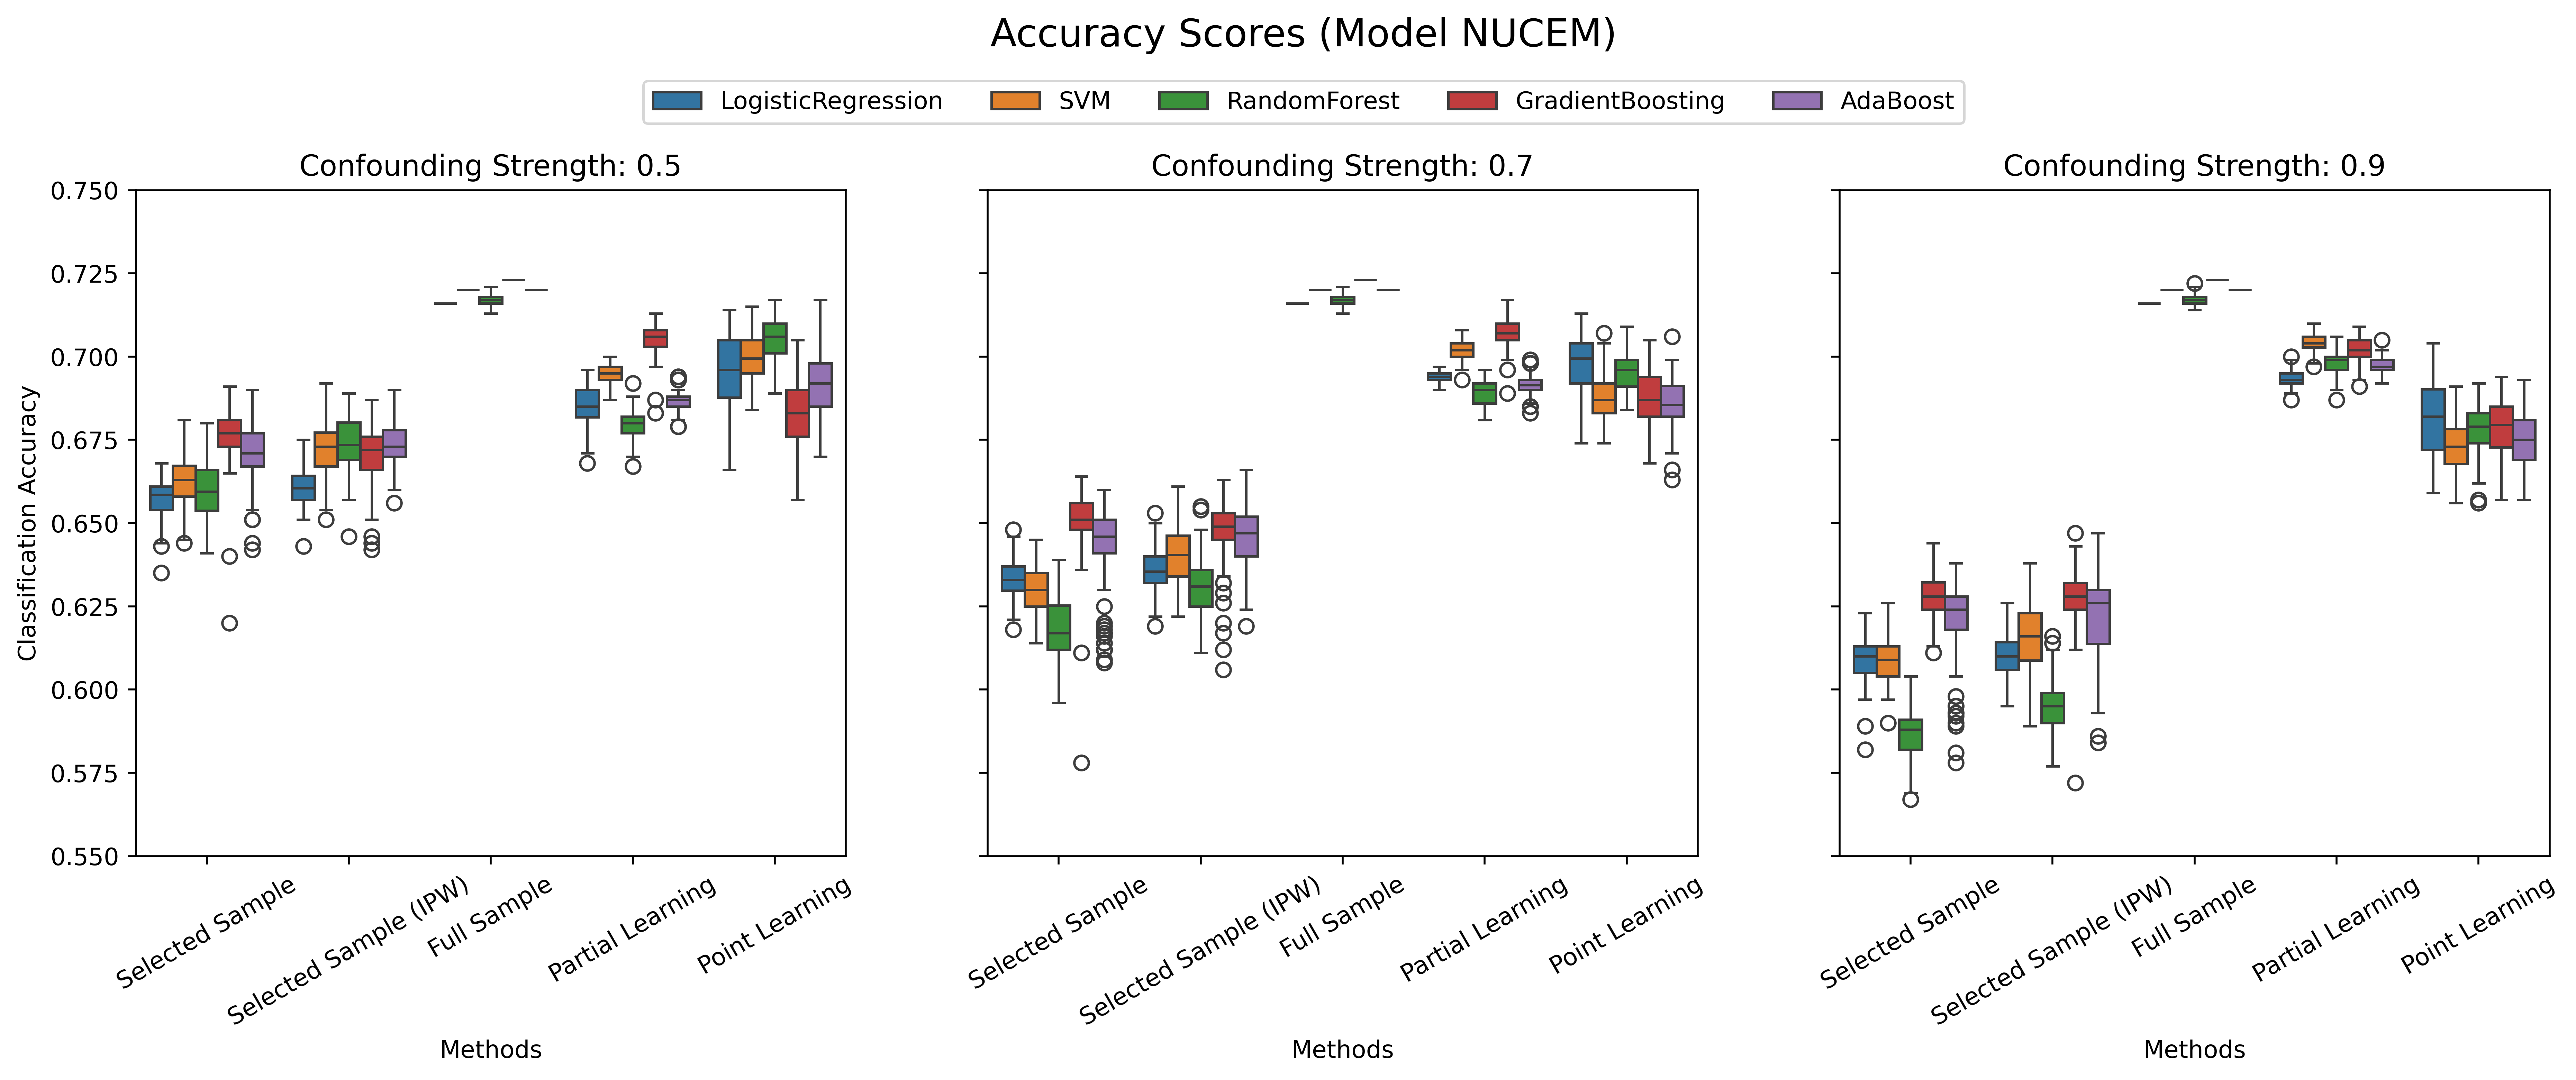

In [17]:
# Boxlots 
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5), dpi=500)
plt.subplots_adjust(hspace=.4)

for k in range(len(confounding_strength_values)):
    key = confounding_strength_values[k]
    acc_df = pd.concat(ACC_pickles_nucem[key], axis=0).stack().reset_index()
    acc_df.columns = ['ML Algorithms', 'Methods', 'Classification Accuracy']

    # Boxplot with accuracy scores,
    bp = sns.boxplot(ax=axes[k], data=acc_df, x='Methods', y='Classification Accuracy', hue='ML Algorithms', 
                     order=['Selected Sample', 'Selected Sample (IPW)', 'Full Sample', 'Partial Learning', 'Point Learning'])
    bp.legend_.remove()

    # Handle legend
    handles, labels = axes[k].get_legend_handles_labels()       
    # axes[k].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axes[k].tick_params(axis='x', rotation=30)
    axes[k].set_title(f'Confounding Strength: {key}')

    # Set y-axis limits
    axes[k].set_ylim(0.55, 0.75)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncols=5)
fig.suptitle('Accuracy Scores (Model NUCEM)', x=0.5, y=1.08, fontsize=16)
# plt.savefig('FICO-NUCEM.png')

## UC Model

In [18]:
confounding_strength_values = [0.5, 0.7, 0.9]
ACC_pickles_uc = dict()

for confounding_strength in confounding_strength_values:
    with open(f'FICO-10-04/FICO-Accuracy-Type-uc-Strength-{confounding_strength}.pickle', 'rb') as handle:
        ACC_pickles_uc[confounding_strength] = pickle.load(handle)

In [19]:
ACC_pickles_uc.keys()

dict_keys([0.5, 0.7, 0.9])

In [20]:
pd.concat(ACC_pickles_uc[0.5], axis=0).reset_index().groupby('index').mean()

,Selected Sample,Selected Sample (IPW),Full Sample,Point Learning,Partial Learning
index,,,,,
AdaBoost,0.65349,0.65113,0.72000,0.64543,0.70465
GradientBoosting,0.65579,0.64907,0.72300,0.63606,0.70929
LogisticRegression,0.65182,0.64226,0.71600,0.65041,0.69883
RandomForest,0.62544,0.64042,0.71747,0.68245,0.69276
SVM,0.63605,0.64514,0.72000,0.66813,0.70251


Text(0.5, 1.1, 'Accuracy Scores (Model UC)')

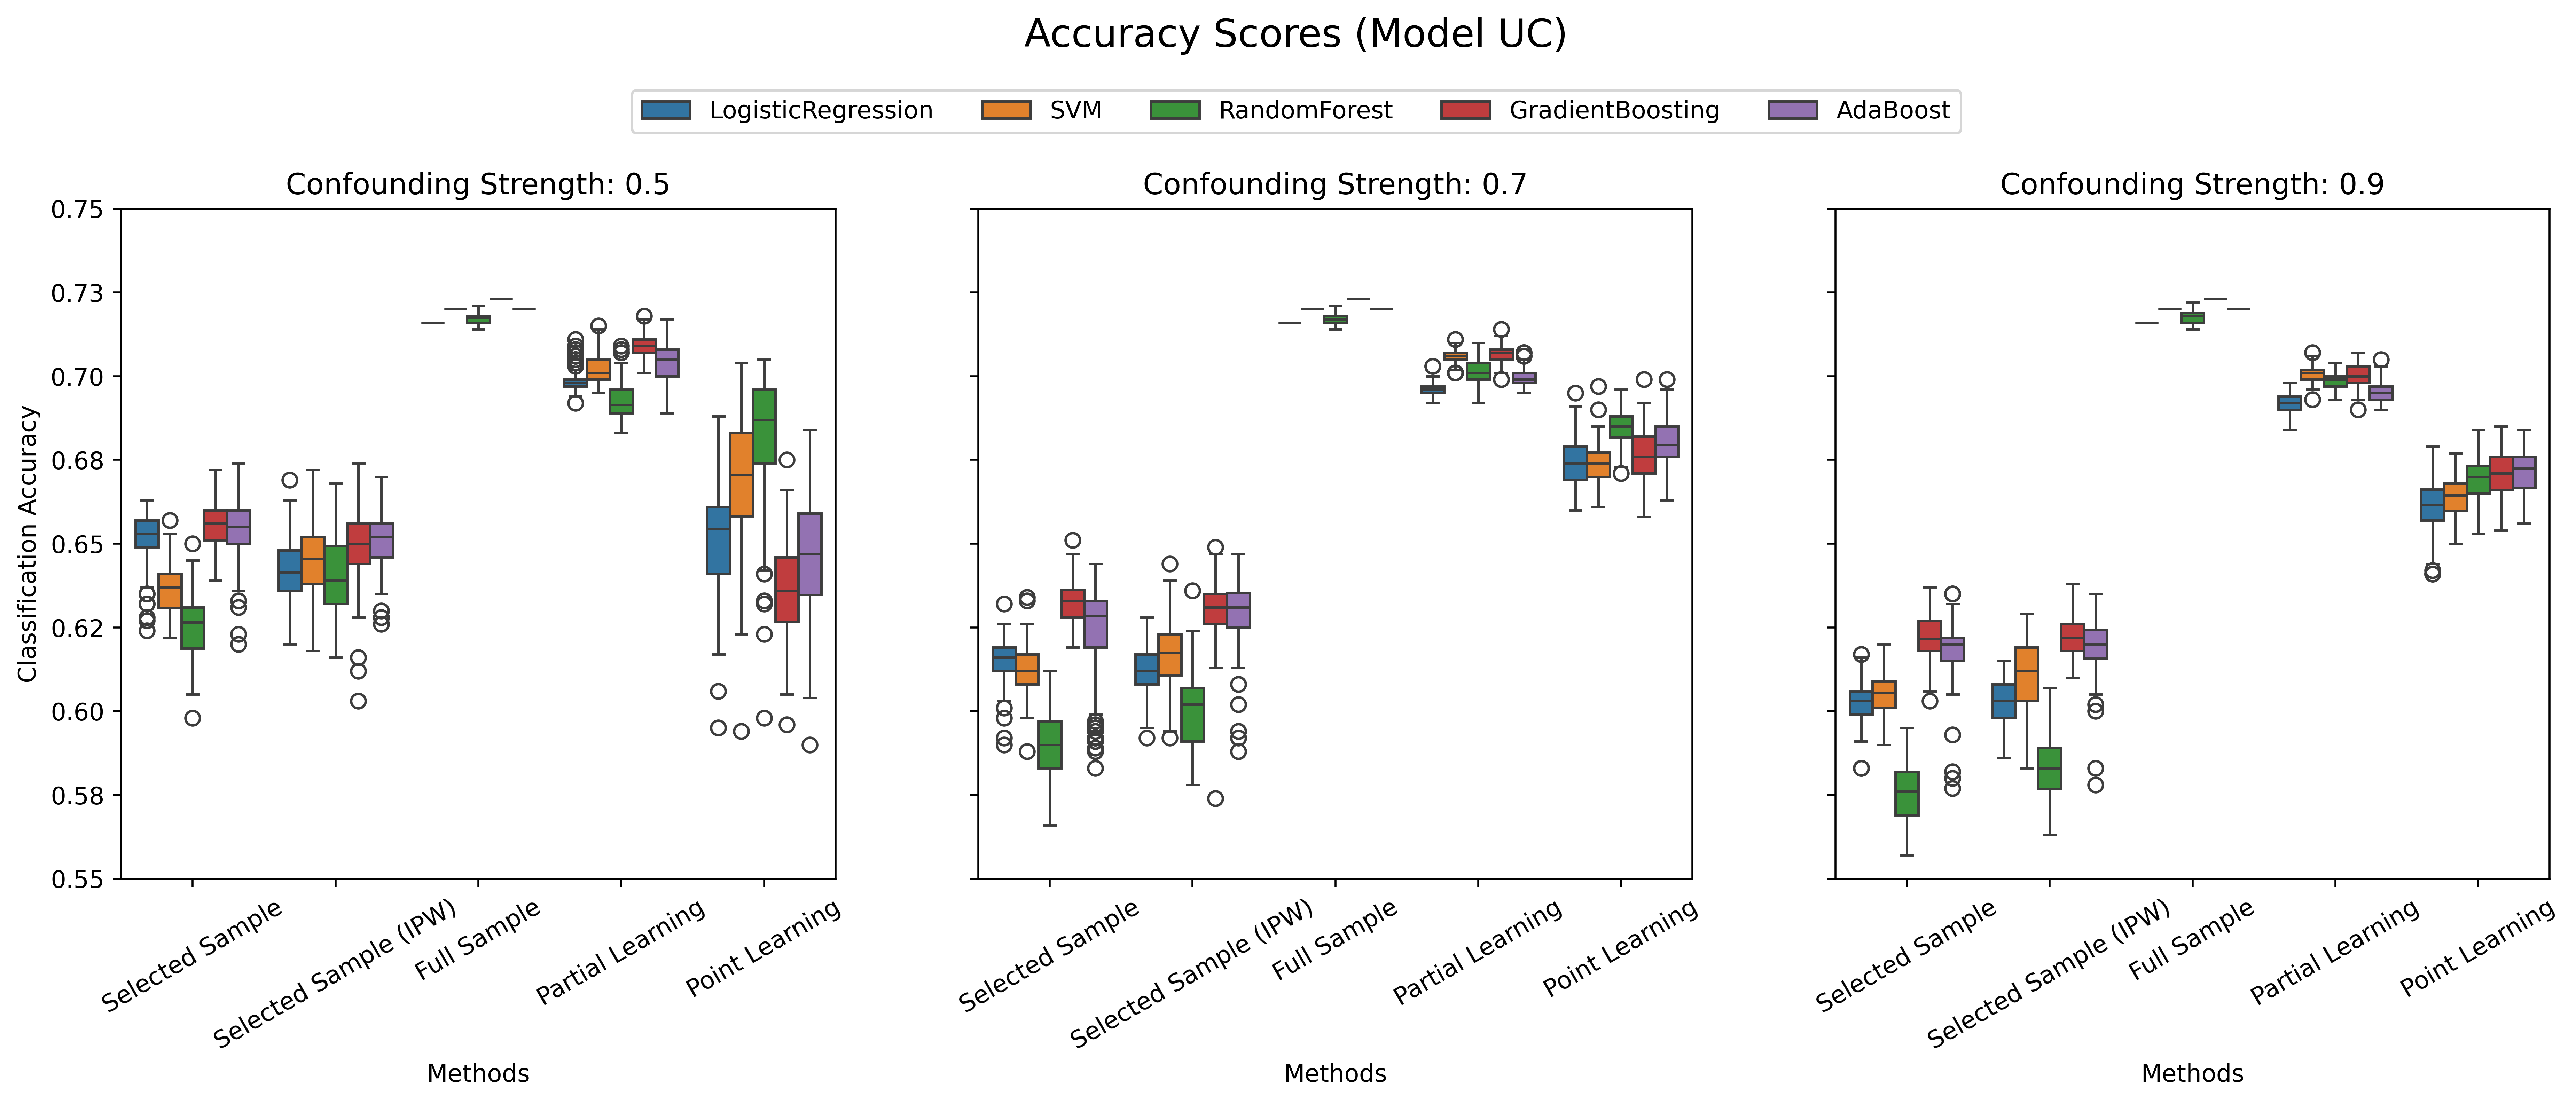

In [21]:
# Boxlots 
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5), dpi=500)
plt.subplots_adjust(hspace=.4)

for k in range(len(confounding_strength_values)):
    key = confounding_strength_values[k]
    acc_df = pd.concat(ACC_pickles_uc[key], axis=0).stack().reset_index()
    acc_df.columns = ['ML Algorithms', 'Methods', 'Classification Accuracy']

    # Boxplot with accuracy scores
    bp = sns.boxplot(ax=axes[k], data=acc_df, x='Methods', y='Classification Accuracy', hue='ML Algorithms', 
                     order=['Selected Sample', 'Selected Sample (IPW)', 'Full Sample', 'Partial Learning', 'Point Learning'])
    bp.legend_.remove()

    # Handle legend
    handles, labels = axes[k].get_legend_handles_labels()       
    axes[k].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axes[k].tick_params(axis='x', rotation=30)
    axes[k].set_title(f'Confounding Strength: {key}')

    # Set y-axis limits
    axes[k].set_ylim(0.55, 0.75)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncols=5)
fig.suptitle('Accuracy Scores (Model UC)', x=0.5, y=1.1, fontsize=16)
# plt.savefig('FICO-UC.pdf')